In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd gdrive/My Drive/test_colab/ml_project2/src

/content/gdrive/My Drive/test_colab/ml_project2/src


In [5]:
! git pull

Already up to date.


In [6]:
!ls ../data

test  train


In [7]:
import sound_processing as sp

In [8]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import glob

In [9]:
#sample_rate, samples = wavfile.read('../data/Pn_GVA_Cases/Pn_GVA_Ca10/audio/Pn_GVA_Ca10_P1.wav')
#sp.show_spec_from_sample(samples , sample_rate)

100%|██████████| 532/532 [06:13<00:00,  1.42it/s]


[[ 0.00766028  0.00840258  0.00873331 ... -0.00172121 -0.00160556
  -0.00148958]
 [ 0.01916664  0.01933206  0.01948978 ...  0.00051267  0.00034104
   0.0001843 ]] Pn P6 Ca 22050 29


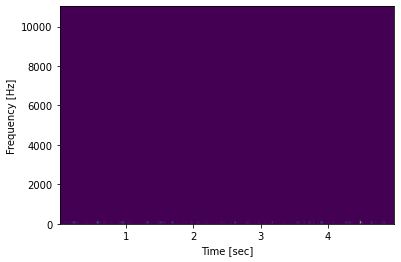

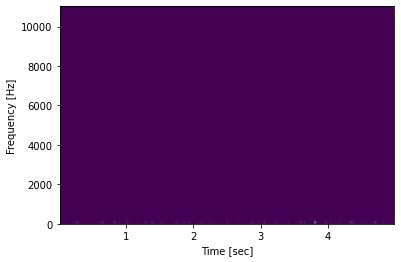

In [10]:
features, diseases, positions, controls, frequences, patientnbs = sp.get_feature_and_labels( '../data/train/*/*/*/'  ) # both control and case

indx = 100 # example on sample nb100
print(features[indx] ,diseases[indx] , positions[indx] , controls[indx] , frequences[indx] , patientnbs[indx])

100%|██████████| 70/70 [01:03<00:00,  1.11it/s]


[[ 5.9706962e-04  6.7813793e-04  7.3362316e-04 ...  1.4544959e-03
   1.4135670e-03  1.3664027e-03]
 [ 4.5743445e-03  4.5443438e-03  4.5135305e-03 ...  6.3816099e-03
   6.5101506e-03  6.6417879e-03]
 [ 1.0954206e-02  1.1060468e-02  1.1153707e-02 ... -2.0139068e-04
  -1.3030520e-04 -6.7431603e-05]
 [-1.6394678e-03 -1.6848879e-03 -1.7421885e-03 ... -2.8045769e-03
  -2.7617300e-03 -2.7151031e-03]] Pn P3 Ca 22050 30


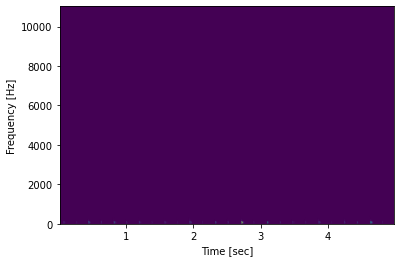

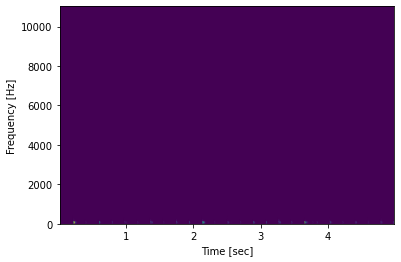

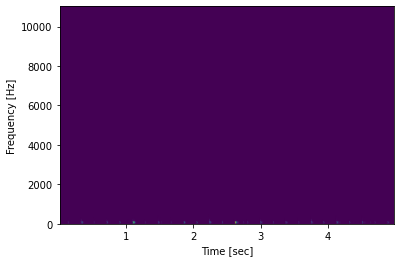

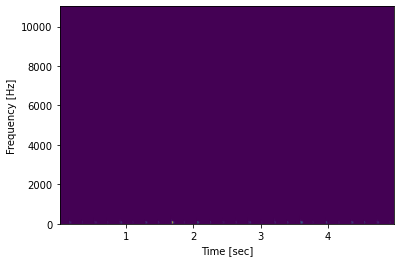

In [11]:
featuresT, diseasesT, positionsT, controlsT, frequencesT, patientnbsT = sp.get_feature_and_labels( '../data/test/*/*/*/'  ) # both control and case

indx = 2 # example on sample nb100
print(featuresT[indx] ,diseasesT[indx] , positionsT[indx] , controlsT[indx] , frequencesT[indx] , patientnbsT[indx])

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization, Activation
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, RemoteMonitor, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

In [58]:
import keras.backend as K
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [358]:
position = 'P5'

indx = positions == position

y_train = (controls[indx] == 'Ca')
x_train = features[indx]

y_train_big = []
x_train_big = []

for i, j in zip(x_train, y_train):
  for subsample in i:
    y_train_big.append(j )
    x_train_big.append(subsample )

y_train = np.array(y_train_big)
x_train = np.array(x_train_big)

print(y_train.shape ,x_train.shape )

(685,) (685, 110250)


In [314]:
indx = positionsT == position

y_test = (controlsT[indx] == 'Ca')
x_test = featuresT[indx]

y_test_big = []
x_test_big = []

for i, j in zip(x_test, y_test):
  for subsample in i:
    y_test_big.append(j )
    x_test_big.append(subsample )

y_test = np.array(y_test_big)
x_test = np.array(x_test_big)

print(y_test.shape ,x_test.shape )
print(y_train.shape)
print(y_train.sum())

(158,) (158, 110250)
(685,)
340


In [315]:
x_train_final = []
x_test_final = []

for sample in x_train:
  x_train_final.append(sp.features_extraction(sample,22050,'stft'))

for sample in x_test:
  x_test_final.append(sp.features_extraction(sample,22050,'stft'))  

x_train_final = np.array(x_train_final)[:,:,:,np.newaxis]
x_test_final = np.array(x_test_final)[:,:,:,np.newaxis]

print(x_train_final.shape,x_test_final.shape)
print(y_train.shape)


(685, 150, 216, 1) (158, 150, 216, 1)
(685,)


In [316]:
#copy

XTr = x_train_final.copy()
XTe = x_test_final.copy()
YTr = y_train.astype(int).copy()
YTe = y_test.astype(int).copy()

print(XTe.shape,XTr.shape)
print(YTe.shape,YTr.shape)


(158, 150, 216, 1) (685, 150, 216, 1)
(158,) (685,)


In [317]:
y_train = to_categorical(YTr)
y_test = to_categorical(YTe)

print(y_train,y_train.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]] (685, 2)


In [318]:
shuffle_indices = np.random.permutation(np.arange(y_train.shape[0]))
y_train = y_train[shuffle_indices]  # rearranges the y_train based on the shuffled indices
XTr = XTr[shuffle_indices]  # rearranges the x_train based on the shuffled indices

In [319]:
print(y_train)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [320]:
shape = XTr.shape[1:]
train_batch_size = 32
train_steps = XTr.shape[0]//train_batch_size # need to specify the number of steps since the data generator outputs continuously


x_test = XTe.astype('float32') # not sure why I do this but let's keep it for now
x_train = XTr.astype('float32')

train_generator = ImageDataGenerator(width_shift_range=20,
                            #height_shift_range=4,
                            #zoom_range=[1/1.3, 1.3],
                            
                            )


train_generator.fit(x_train) #apply the augmetnation to train data

train_datagen = train_generator.flow(x_train, y_train, batch_size=train_batch_size) # creates the mii batch flow



In [ ]:
model = Sequential()

model.add(Convolution2D(20, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(50, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
dense1_unit = 25
model.add(Dense(dense1_unit, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.00004, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy',f1])
#model.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])

#Callbacks

checkpointer = ModelCheckpoint(monitor='val_accuracy', # automatically saves the model 
                               mode='auto', 
                               filepath='../XXX'+position+'_D'+str(dense1_unit)+'.h5',
                               verbose=1,
                               save_best_only=True,
                               save_freq = 'epoch'
                              )

csv_logger = CSVLogger('../test_model.txt') # saves the output log in csv


#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, # can be used to reduce the learning rate once the model stops learning
                       #min_delta=0.001, cooldown=1,
                       #verbose=1, patience=10,
                       # min_lr=4.0e-5)

#FitTheModel

history = model.fit_generator(train_datagen,
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=(x_test, y_test),
                              #callbacks= [checkpointer]
                              )
                              
                              

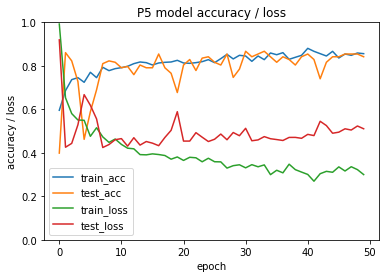

In [324]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(position+' model accuracy / loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc','train_loss','test_loss'], loc='lower left')
plt.ylim(ymax = 1, ymin = 0)
plt.show()


In [175]:
!ls ../

data  P1_D25.h5  P2_D25.h5  P3_D25.h5  P8_D25.h5  README.md  src  test_model.h5


In [ ]:
print(x_test.shape, y_test.shape)

In [267]:
model.load_weights('../P1_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.3566 - accuracy: 0.8782 - f1: 0.8813
[0.35656261444091797, 0.8782051205635071, 0.8812500238418579]
23/23 [==============================] - 0s 10ms/step - loss: 0.3562 - accuracy: 0.8390 - f1: 0.8390
[0.35621216893196106, 0.8390177488327026, 0.8389710187911987]


In [286]:
model.load_weights('../P2_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

6/6 [==============================] - 0s 8ms/step - loss: 0.4654 - accuracy: 0.8793 - f1: 0.8906
[0.4653988182544708, 0.8793103694915771, 0.890625]
25/25 [==============================] - 0s 10ms/step - loss: 0.3530 - accuracy: 0.8440 - f1: 0.8500
[0.3529934883117676, 0.8439531922340393, 0.8499999046325684]


In [299]:
model.load_weights('../P3_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.4525 - accuracy: 0.8630 - f1: 0.8750
[0.4524646997451782, 0.8630136847496033, 0.875]
23/23 [==============================] - 0s 10ms/step - loss: 0.3886 - accuracy: 0.8249 - f1: 0.8125
[0.388602077960968, 0.8248587846755981, 0.8124999403953552]


In [312]:
model.load_weights('../P4_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.6246 - accuracy: 0.8618 - f1: 0.8687
[0.6245535016059875, 0.8618420958518982, 0.8687499761581421]
24/24 [==============================] - 0s 10ms/step - loss: 0.3446 - accuracy: 0.8360 - f1: 0.8370
[0.34460458159446716, 0.8359788656234741, 0.83697909116745]


In [325]:
model.load_weights('../P5_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 9ms/step - loss: 0.5127 - accuracy: 0.8671 - f1: 0.8687
[0.5127297043800354, 0.8670886158943176, 0.8687499761581421]
22/22 [==============================] - 0s 11ms/step - loss: 0.3270 - accuracy: 0.8292 - f1: 0.8317
[0.32703477144241333, 0.829197108745575, 0.8317306637763977]


In [222]:
model.load_weights('../P6_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

6/6 [==============================] - 0s 8ms/step - loss: 0.4505 - accuracy: 0.8466 - f1: 0.7691
[0.45051729679107666, 0.8466257452964783, 0.7690972685813904]
21/21 [==============================] - 0s 10ms/step - loss: 0.3554 - accuracy: 0.8418 - f1: 0.8419
[0.35542550683021545, 0.841791033744812, 0.8418650031089783]


In [233]:
model.load_weights('../P7_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.1254 - accuracy: 0.9740 - f1: 0.9692
[0.12539531290531158, 0.9740259647369385, 0.9692307710647583]
24/24 [==============================] - 0s 10ms/step - loss: 0.1629 - accuracy: 0.9367 - f1: 0.9351
[0.16294337809085846, 0.936675488948822, 0.9351325631141663]


In [250]:
model.load_weights('../P8_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.9935 - f1: 0.9937
[0.1845911741256714, 0.9934640526771545, 0.9937499761581421]
26/26 [==============================] - 0s 10ms/step - loss: 0.3284 - accuracy: 0.8712 - f1: 0.8697
[0.3283524811267853, 0.8711656332015991, 0.8697114586830139]


In [328]:
stat = [[0.35656261444091797, 0.8782051205635071, 0.8812500238418579],
        [0.4653988182544708, 0.8793103694915771, 0.890625],
        [0.4524646997451782, 0.8630136847496033, 0.875],
        [0.6245535016059875, 0.8618420958518982, 0.8687499761581421],
        [0.5127297043800354, 0.8670886158943176, 0.8687499761581421],
        [0.45051729679107666, 0.8466257452964783, 0.7690972685813904],
        [0.12539531290531158, 0.9740259647369385, 0.9692307710647583],
        [0.1845911741256714, 0.9934640526771545, 0.9937499761581421]]
stat = np.array(stat)

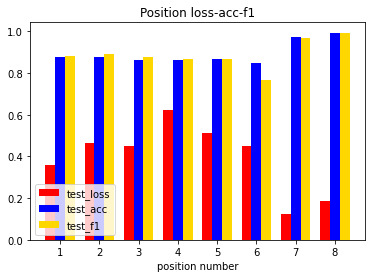

In [359]:
for i in np.arange(stat.shape[0]):
  plt.bar(i+1 + -0.25, stat[i][0], color = 'r', width = 0.25)
  plt.bar(i+1 + 0., stat[i][1], color = 'b', width = 0.25)
  plt.bar(i+1 + 0.25, stat[i][2], color = 'gold', width = 0.25)

plt.title('Position loss-acc-f1')
plt.legend(['test_loss', 'test_acc','test_f1'], loc='lower left')
plt.xlabel('position number')
plt.show()

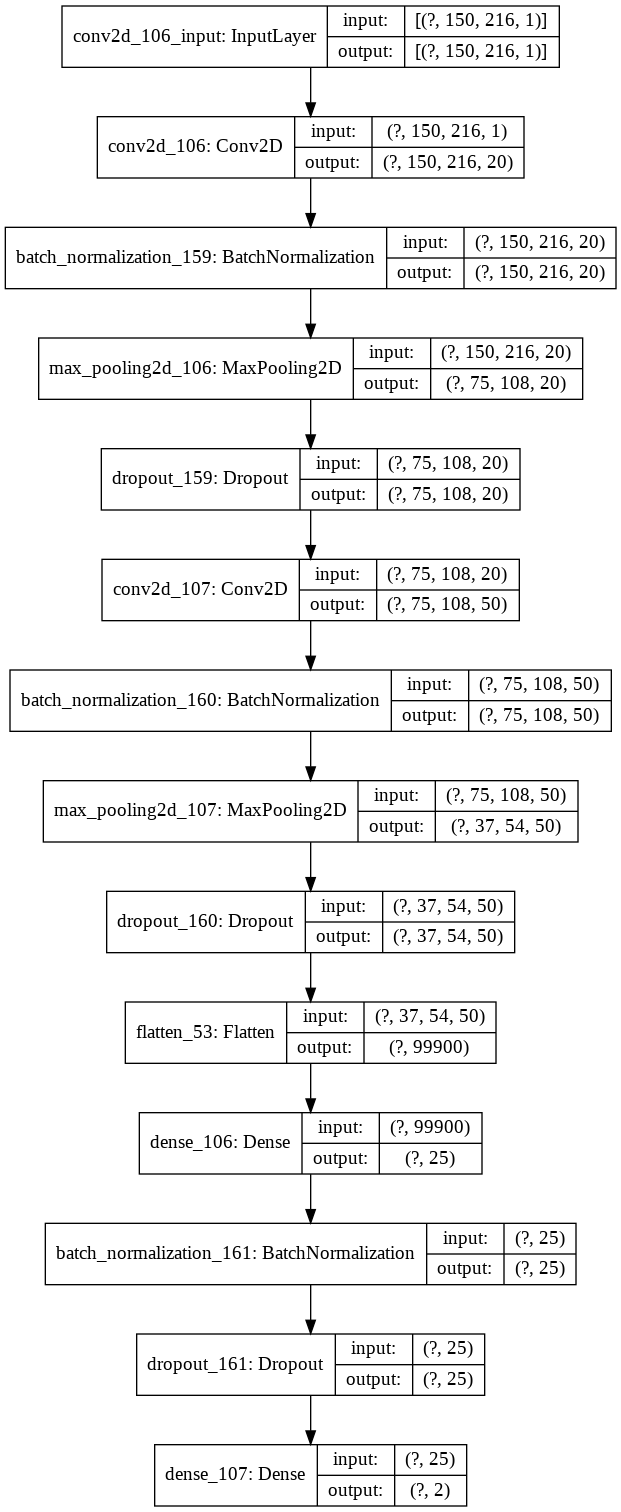

In [362]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)